# Web APIs & NLP - Modeling

## Contents:
- [EDA (Exploratory Data Analysis)](#EDA-(Exploratory-Data-Analysis))
- [Imports & Data](#Imports-\&-Data)
- [Modeling](#Modeling)
- [Ensemble Modeling](#Ensemble-Modeling)
- [Conclusions & Recommendations](#Conclusions-\&-Recommendations)

## EDA (Exploratory Data Analysis)

## Imports & Data

#### Libraries

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn imports 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import XGBoost Classifier
from xgboost import XGBClassifier

# Import pickle to save models
import pickle

#### Read in Data

In [2]:
# Display long posts in dfs
pd.options.display.max_colwidth = 8600 # allow full display of post

In [3]:
# Review data that was read in
df = pd.read_csv('../data/reddit_processed.csv')
print(df.shape)
df.head()

(8000, 9)


,subreddit,selftext,cleaned_selftext,post_length,post_word_count,no_stop_selftext,stem_selftext,lemmatize_selftext,no_shared_stem_selftext
0,0,"Hey everyone,\n\nMy late father was a DJ in socal throughout the 70s-90s and was obviously pretty big into music. He had a pair of RSL speakers that he never told me the name of before he passed. Are there any audiophiles that has some knowledge on vintage RSL speakers???\n\n\nAlso, i spliced some RCA cables to see if they even worked, and they did, but they are extremely quiet even with everything on full and running it through my 48v mixer. (it almost sounds like it is just the tweeter). Does anyone know if im missing something?\n\nAny help would be greatly appreciated. :)\n\nHere are some photos of the speakers:\nhttps://imgur.com/a/oAhF08F",Hey everyone My late father was a DJ in socal throughout the ss and was obviously pretty big into music He had a pair of RSL speakers that he never told me the name of before he passed Are there any audiophiles that has some knowledge on vintage RSL speakers Also i spliced some RCA cables to see if they even worked and they did but they are extremely quiet even with everything on full and running it through my v mixer it almost sounds like it is just the tweeter Does anyone know if im missing something Any help would be greatly appreciated Here are some photos of the speakers,641,113,Hey everyone My late father DJ socal throughout ss obviously pretty big music He pair RSL speakers never told name passed Are audiophiles knowledge vintage RSL speakers Also spliced RCA cables see even worked extremely quiet even everything full running v mixer almost sounds like tweeter Does anyone know im missing something Any help would greatly appreciated Here photos speakers,hey everyon my late father dj socal throughout ss obvious pretti big music he pair rsl speaker never told name pass are audiophil knowledg vintag rsl speaker also splice rca cabl see even work extrem quiet even everyth full run v mixer almost sound like tweeter doe anyon know im miss someth ani help would greatli appreci here photo speaker,Hey everyone My late father DJ socal throughout s obviously pretty big music He pair RSL speaker never told name passed Are audiophiles knowledge vintage RSL speaker Also spliced RCA cable see even worked extremely quiet even everything full running v mixer almost sound like tweeter Does anyone know im missing something Any help would greatly appreciated Here photo speaker,hey everyon my late father dj socal throughout ss obvious pretti big he pair rsl speaker never told name pass are audiophil knowledg vintag rsl speaker also splice rca cabl see even work extrem quiet even everyth full run v mixer almost sound tweeter doe miss ani greatli appreci here photo speaker
1,0,I recently bought a Dual Kicker Comp R 12” sub and Audiocontrol LC-1.800 amp and I think they sound good but I have been having a problem since install where it will randomly make a constant windy air sound usually when I get in my car and it persists for about 2-3 minutes even when no music is playing. It will also do it as I’m driving every now and then. I took it in to where I had it installed and the guy disabled the ANC in my car because he thought my subs were picking up on it but that didn’t fix the problem. Would anyone have any idea why this is happening?,I recently bought a Dual Kicker Comp R sub and Audiocontrol LC amp and I think they sound good but I have been having a problem since install where it will randomly make a constant windy air sound usually when I get in my car and it persists for about minutes even when no music is playing It will also do it as Im driving every now and then I took it in to where I had it installed and the guy disabled the ANC in my car because he thought my subs were picking up on it but that didnt fix the problem Would anyone have any idea why this is happening,570,115,I recently bought Dual Kicker Comp R sub Audiocontrol LC amp I think sound goo

## Modeling

### Set up X and y
- Multiple X-data sets were tested to determine which method of NLP performed the best.
- The data that had English stopwords and most common shared words removed and then was stemmed performed the best.
- This cell lists (in comments) the various data sets that were tested.

In [4]:
# Define target (y)
y = df['subreddit']

# Define X - Multiple X-data sets were tested to determine which method of NLP performed the best
X = df['no_shared_stem_selftext'].astype('str') # Stemmed Data (Stopwords + most common shared words dropped)

# All X's below were tested and did not perform as well as the selected X.
# X = df['selftext'].astype('str') # Uncleaned Data
# X = df['cleaned_selftext'].astype('str') # Uncleaned Data
# X = df['no_stop_selftext'].astype('str') # Stopwords dropped
# X = df['stem_selftext'].astype('str') # Stemmed Data (no stopwords)
# X = df['lemmatize_selftext'].astype('str') # Lemmatized Data (no stopwords)

### Define the baseline score

In [5]:
# Baseline
baseline = y.value_counts(normalize=True)[1]
print(f"The baseline is {baseline}")

The baseline is 0.5


#### Baseline
- The baseline is 50% because the dataset is balanced.
- In other words, because half of the data set is from one subreddit and half is from another, if you simply predicted '1' (r/guitar') for every post, you would be correct 50% of the time.

### Train Test Split
- A Train/Test split of 75/25 was used for this data set of 8000 subreddit posts.

In [6]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

### Define Pipelines
- Individual pipelines were set up for each model to be tested. The tested models are:
    - Multinomial Naive Bayes
    - Logistic Regression
    - Random Forest
    - Extra Trees
    - Gradient Boosting
    - XGBoost
    - Support Vector Machine (SVM)
- Multiple models were tested to demonstrate their strengths and weaknesses to determine which model is optimal for this problem.
- Dictionaries of hyperparameters were also set up to perform a gridsearch across.
- From these multiple pipelines and hyperparameters, model types and their parameters can be optimized.

In [7]:
# Define pipelines
# Naive Bayes Pipeline
pipe_nb = Pipeline([
    ('tfidf', CountVectorizer()), # CountVectorizer performed better than TfidfVectorizer (different than other models)
    ('clf', MultinomialNB())
])

# Logistic Regression Pipeline
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer()), # TfidfVectorizer performed better than CountVectorizer
    ('clf', LogisticRegression())
])

# Random Forest Pipeline
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer()), # TfidfVectorizer performed better than CountVectorizer
    ('clf', RandomForestClassifier())
])

# Extra Trees Pipeline
pipe_et = Pipeline([
    ('tfidf', TfidfVectorizer()), # TfidfVectorizer performed better than CountVectorizer
    ('clf', ExtraTreesClassifier())
])

# Gradient Boosting Pipeline
pipe_gb = Pipeline([
    ('tfidf', TfidfVectorizer()), # TfidfVectorizer performed better than CountVectorizer
    ('clf', GradientBoostingClassifier())
])

# XGBoost Pipeline
pipe_xg = Pipeline([
    ('tfidf', TfidfVectorizer()), # TfidfVectorizer performed better than CountVectorizer
    ('clf', XGBClassifier()) # (https://xgboost.readthedocs.io/en/stable/python/python_intro.html)
])

# SVM (Support Vector Machine) Pipeline
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer()), # TfidfVectorizer performed better than CountVectorizer
    ('clf', SVC(probability=True))
])

# Combine pipelines into a list of pipelines
pipes = [pipe_nb,
         pipe_lr,
         pipe_rf,
         pipe_et,
         pipe_gb,
         pipe_xg,
         pipe_svc]

pipe_names = ['Naive Bayes',
              'Logistic Regression',
              'Random Forest',
              'Extra Trees',
              'Gradient Boosting',
              'XGBoost',
              'SVM']

In [8]:
# Define hyperparameters for each pipeline to gridsearch over
# Naive Bayes Hyperparameters
hp_nb = {'tfidf__max_df': [0.5], # Tested parameters: [0.5, 0.75, 1.0]
         'tfidf__ngram_range': [(1, 2)], # Tested parameters: [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
         'clf__alpha': [0.5]} # Tested parameters: [0, 0.01, 0.1, 0.5, 1.0]

# Logistic Regression Hyperparameters
hp_lr = {'tfidf__max_df': [0.5], # Tested parameters: [0.5, 0.75, 1.0]
         'tfidf__ngram_range': [(1, 1)], # Tested parameters: [(1, 1), (1, 2)]
         'clf__penalty': ['l2'], # Tested parameters: ['l1', 'l2']
         'clf__C': [3]} # Tested parameters: np.linspace(0, 10, 11)

# Random Forest Hyperparameters
hp_rf = {'tfidf__max_df': [0.5], # Tested parameters: [0.5, 0.75, 1.0]
         'tfidf__ngram_range': [(1, 1)], # Tested parameters: [(1, 1), (1, 2)]
         'clf__n_estimators': [300], # Tested parameters: [200, 300, 400, 1000, 2000, 3000]
         'clf__max_depth': [22]} # Tested parameters: [5, 7, 10, 12, 15, 18, 22, 25]

# Extra Trees Hyperparameters
hp_et = {'tfidf__max_df': [1.0], # Tested parameters: [0.5, 0.75, 1.0]
         'tfidf__ngram_range': [(1, 2)], # Tested parameters: [(1, 1), (1, 2)]
         'clf__n_estimators': [1000], # Tested parameters: [200, 300, 400, 500, 1000, 2000, 3000]
         'clf__max_depth': [18]} # Tested parameters: [5, 7, 10, 12, 15, 18, 22, 25]

# Gradient Boosting Hyperparameters
hp_gb = {'tfidf__max_df': [1.0], # Tested parameters: [0.5, 0.75, 1.0]
         'tfidf__ngram_range': [(1, 2)], # Tested parameters: [(1, 1), (1, 2)]
         'clf__n_estimators': [1000], # Tested parameters: [10, 100, 300, 500, 1000]
         'clf__max_depth': [3], # Tested parameters: [None, 1, 2, 3, 4, 5, 10, 18]
         'clf__learning_rate': [0.1]} # Tested parameters: [0.01, 0.1, 1, 10]

# XGBoost Hyperparameters
hp_xg = {'tfidf__max_df': [0.5], # Tested parameters: [0.5, 0.75, 1.0]
         'tfidf__ngram_range': [(1, 2)], # Tested parameters: [(1, 1), (1, 2)]
         'clf__n_estimators': [500], # Tested parameters: [10, 100, 500, 1000]
         'clf__max_depth': [3], # Tested parameters: [1, 2, 3, 5, 7, 12, 18]
         'clf__learning_rate': [0.1]} # Tested parameters: [0.1, 1, 10]

# SVM (Support Vector Machine) Hyperparameters
hp_svc = {'tfidf__max_df': [0.5], # Tested parameters: [0.5, 0.75, 1.0]
         'tfidf__ngram_range': [(1, 1)], # Tested parameters: [(1, 1), (1, 2)]
         'clf__C': [1], # Tested parameters: np.logspace(-3, 1, 10)
         'clf__kernel': ['rbf']} # Tested parameters: ['rbf', 'poly']

# Combine hyperparameters into a list of hyperparameters
hps = [hp_nb,
       hp_lr,
       hp_rf,
       hp_et,
       hp_gb,
       hp_xg,
       hp_svc]

#### Fit Models
- Loop over each pipeline and perform a gridsearch accross the parameters to explore
- The hyperparameters determined in the previous cell have been narrowed after multiple iterations to improve performance and reduce compute time.
- The loop is construected to output performance metrics of each model once it has been fit.
- All models are saved to the './models' folder for later reference and to ensemble.

In [9]:
%%time
# Fit and evaluate pipelines using GridSearchCV

cms = [] # initialize list of confusion matricies

# Loop over each pipeline to gridsearch, fit, evaluate, and save the model
for pipe, name, pgrid in zip(pipes, pipe_names, hps):
    # Gridsearch to find the best model
    gs = GridSearchCV(estimator=pipe, param_grid=pgrid, cv=5, n_jobs=6)
    
    # Fit the best model
    gs.fit(X_train, y_train)
    
    # Save the best model to disk
    filename = f"{name}.pkl"
    pickle.dump(gs, open(f"../models/individual/{filename}", 'wb'))
    
    # Make predictions (for metrics)
    y_pred = gs.predict(X_test)
    
    # Append to list of confusion matricies for later plotting
    cms.append(confusion_matrix(y_test, y_pred))
    
    # Print performance metrics
    print(f" {name} ".center(26, "="))
    print(f"Test Accuracy: {round(gs.score(X_test, y_test), 3)}")
    print(f"Train Accuracy: {round(gs.score(X_train, y_train), 3)}")
    print(f"Precision: {round(precision_score(y_test, y_pred), 3)}")
    print(f"Recall: {round(recall_score(y_test, y_pred), 3)}")
    print(f"F1 Score: {round(f1_score(y_test, y_pred), 3)}")
    print(f"Best parameters: {gs.best_params_}") # best parameters
    print()

====== Naive Bayes =======
Test Accuracy: 0.96
Train Accuracy: 0.998
Precision: 0.955
Recall: 0.965
F1 Score: 0.96
Best parameters: {'clf__alpha': 0.5, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}

== Logistic Regression ===
Test Accuracy: 0.96
Train Accuracy: 0.994
Precision: 0.967
Recall: 0.953
F1 Score: 0.96
Best parameters: {'clf__C': 3, 'clf__penalty': 'l2', 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}

===== Random Forest ======
Test Accuracy: 0.942
Train Accuracy: 0.968
Precision: 0.924
Recall: 0.962
F1 Score: 0.943
Best parameters: {'clf__max_depth': 22, 'clf__n_estimators': 300, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}

====== Extra Trees =======
Test Accuracy: 0.948
Train Accuracy: 0.977
Precision: 0.936
Recall: 0.962
F1 Score: 0.949
Best parameters: {'clf__max_depth': 18, 'clf__n_estimators': 1000, 'tfidf__max_df': 1.0, 'tfidf__ngram_range': (1, 2)}

=== Gradient Boosting ====
Test Accuracy: 0.936
Train Accuracy: 1.0
Precision: 0.951
Recall: 0.919
F1

#### Confusion Matrices
- Review the performance of each model through confusion matrices.

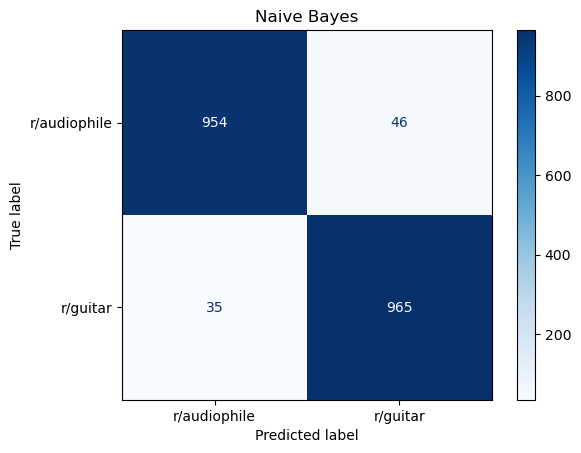

In [10]:
# Plot confusion matrix for review
disp = ConfusionMatrixDisplay(confusion_matrix=cms[0], display_labels=['r/audiophile', 'r/guitar'])
disp.plot(cmap = 'Blues')
plt.title(pipe_names[0]);

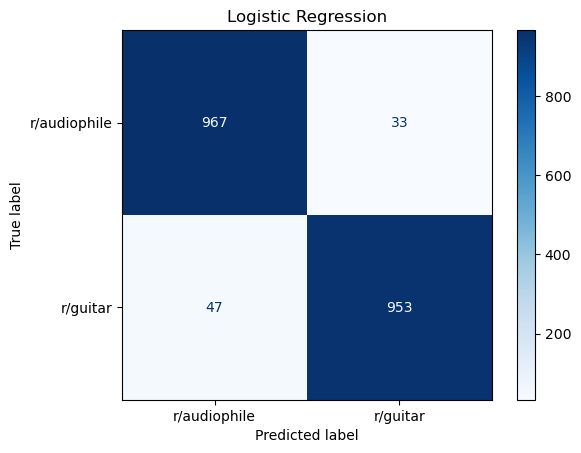

In [11]:
# Plot confusion matrix for review
disp = ConfusionMatrixDisplay(confusion_matrix=cms[1], display_labels=['r/audiophile', 'r/guitar'])
disp.plot(cmap = 'Blues')
plt.title(pipe_names[1]);

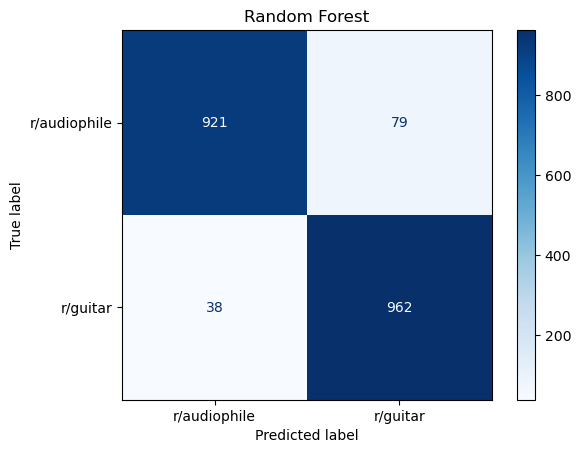

In [12]:
# Plot confusion matrix for review
disp = ConfusionMatrixDisplay(confusion_matrix=cms[2], display_labels=['r/audiophile', 'r/guitar'])
disp.plot(cmap = 'Blues')
plt.title(pipe_names[2]);

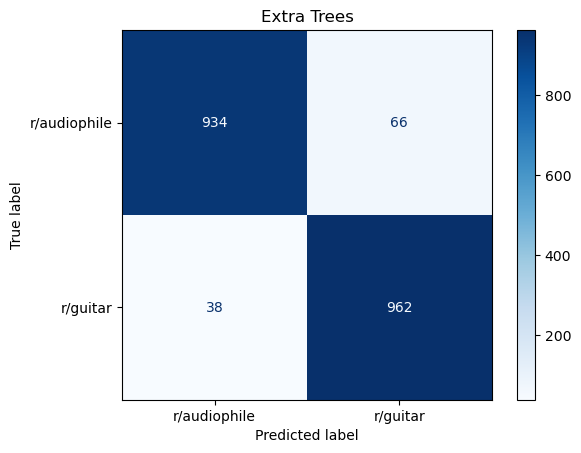

In [13]:
# Plot confusion matrix for review
disp = ConfusionMatrixDisplay(confusion_matrix=cms[3], display_labels=['r/audiophile', 'r/guitar'])
disp.plot(cmap = 'Blues')
plt.title(pipe_names[3]);

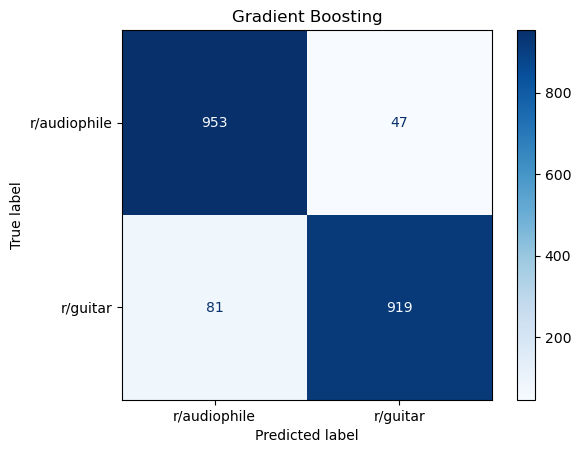

In [14]:
# Plot confusion matrix for review
disp = ConfusionMatrixDisplay(confusion_matrix=cms[4], display_labels=['r/audiophile', 'r/guitar'])
disp.plot(cmap = 'Blues')
plt.title(pipe_names[4]);

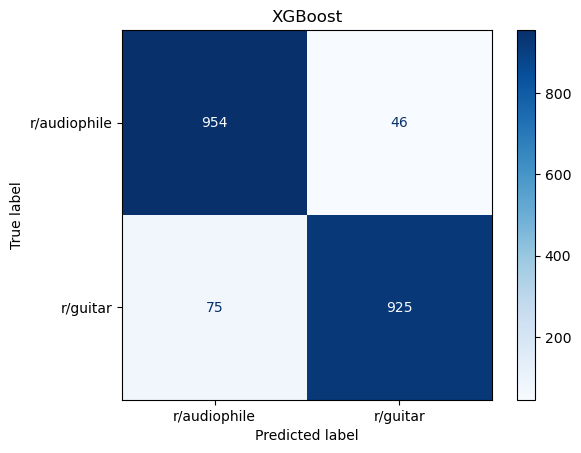

In [15]:
# Plot confusion matrix for review
disp = ConfusionMatrixDisplay(confusion_matrix=cms[5], display_labels=['r/audiophile', 'r/guitar'])
disp.plot(cmap = 'Blues')
plt.title(pipe_names[5]);

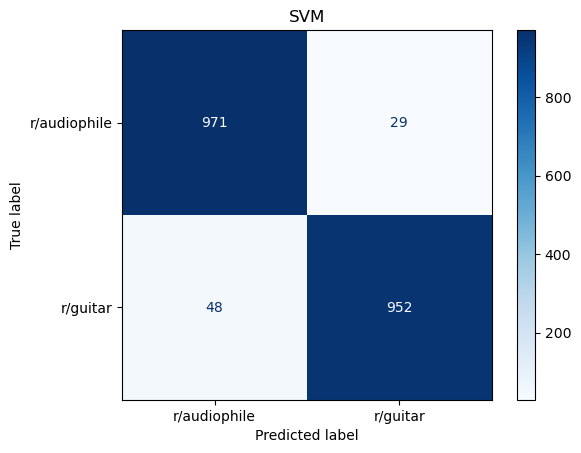

In [16]:
# Plot confusion matrix for review
disp = ConfusionMatrixDisplay(confusion_matrix=cms[6], display_labels=['r/audiophile', 'r/guitar'])
disp.plot(cmap = 'Blues')
plt.title(pipe_names[6]);

### Model Performance Summary
Below are the final performance metrics for each model that was tested.
*NOTE:* All models were overfit. However, any attempt to make them less overfit resulted in a reduction in overall performance. Therefore, even though the models are overfit, these are still their optimal versions.

|**Model**|**Accuracy**|**Precision**|**Recall (Sensitivity)**|
|---|---|---|---|
|**Multinomial Naive Bayes**|0.960|0.955|0.965|
|**Logistic Regression**|0.960|0.967|0.953|
|**Random Forest**|0.942|0.924|0.962|
|**Extra Trees**|0.948|0.936|0.962|
|**Gradient Boosting**|0.936|0.951|0.919|
|**XGBoost**|0.940|0.953|0.925|
|**SVM**|0.962|0.970|0.952|

# Ensemble Modeling
### Load Models, Combine, Vote, and Predict
- Once all models have been fit and assessed, they can be ensembled together to improve predictions.
- Selected models are to be loaded into the notebook, ensembled, and then fit to the data using a VotingClassifier. This combines all models into a single model by taking a majority vote of their predictions.

In [17]:
# load the model from disk
final_models = []
print(f" Loaded Model Performances ".center(34, "="))
for name in pipe_names:
    # Load in models and append to list of final models
    loaded_model = pickle.load(open(f"../models/individual/{name}.pkl", 'rb'))
    final_models.append(loaded_model)
    
    # Print accuracy to confirm correct models
    model_score = loaded_model.score(X_test, y_test)
    print(f"{name} Accuracy: {model_score}")

=== Loaded Model Performances ====
Naive Bayes Accuracy: 0.9595
Logistic Regression Accuracy: 0.96
Random Forest Accuracy: 0.9415
Extra Trees Accuracy: 0.948
Gradient Boosting Accuracy: 0.936
XGBoost Accuracy: 0.9395
SVM Accuracy: 0.9615


In [18]:
%%time
# Initialize VotingClassifier for ensembling (https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/)
voting = VotingClassifier(estimators=[('nb', final_models[0]),
                                      ('lr', final_models[1]),
                                      ('svc', final_models[6])],
                          voting='hard',
                          n_jobs=6)

# fit VotingClassifier
voting.fit(X_train, y_train)

# Make predictions on test data
y_pred = voting.predict(X_test)

# Evaluate the accuracy of the ensemble model
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
cm_bagged = confusion_matrix(y_test, y_pred)

# Print performance metrics
print(f" Combined Models ".center(26, "="))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

==== Combined Models =====
Test Accuracy: 0.962
Precision: 0.9695121951219512
Recall: 0.954
F1 Score: 0.9616935483870968
CPU times: total: 2.3 s
Wall time: 1min 41s


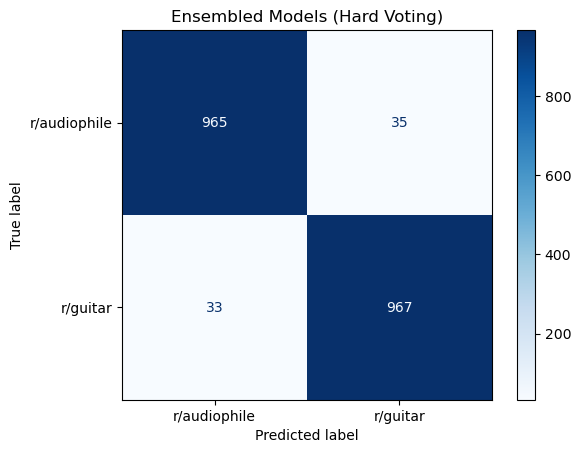

In [22]:
# Plot confusion matrix for review
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bagged, display_labels=['r/audiophile', 'r/guitar'])
disp.plot(cmap = 'Blues')
plt.title("Ensembled Models (Hard Voting)");

In [20]:
%%time
# Initialize VotingClassifier for ensembling (https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/)
voting_soft = VotingClassifier(estimators=[('nb', final_models[0]),
                                           ('lr', final_models[1]),
                                           ('svc', final_models[6])],
                               voting='soft',
                               n_jobs=6)

# fit VotingClassifier
voting_soft.fit(X_train, y_train)

# Save the best model to disk
filename = f"final_reddit_model.pkl"
pickle.dump(voting_soft, open(f"../models/{filename}", 'wb'))

# Make predictions on test data
y_pred = voting_soft.predict(X_test)

# Evaluate the accuracy of the ensemble model
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
cm_bagged = confusion_matrix(y_test, y_pred)

# Print performance metrics
print(f" Combined Models ".center(26, "="))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

==== Combined Models =====
Test Accuracy: 0.966
Precision: 0.9650698602794411
Recall: 0.967
F1 Score: 0.9660339660339661
CPU times: total: 2.42 s
Wall time: 1min 42s


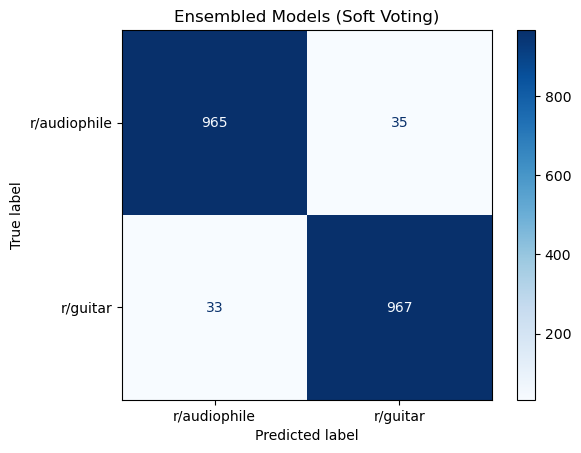

In [23]:
# Plot confusion matrix for review
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bagged, display_labels=['r/audiophile', 'r/guitar'])
disp.plot(cmap = 'Blues')
plt.title("Ensembled Models (Soft Voting)");

### Final Model Performance Summary
|**Model**|**Accuracy**|**Precision**|**Recall (Sensitivity)**|
|---|---|---|---|
|**Ensembled Model** (Multinomial Naive Bayes, Logistic Regression, SVM)|0.966|0.965|0.967|

## Conclusions & Recommendations

### Conclusion
Through these technical notebook reports, our team has scraped text data from subreddit posts, cleaned/preprocessed/and analyzed the text data, and trained multiple models on the data. This process required many iterations to optimize each step.

During the data gathering stage, an API (Pushshift) was leveraged to scrape posts from specific subreddits. This API allowed for a more streamlined process of collecting Reddit data than traditional web scraping. However, the text was unprocessed and contained many anomalies. The data went through a cleaning process before NLP processing began. Cleaning consisted of removing or processing urls, brackets, parenthesis, new line characters, Reddit-specific character sequences, emojis, numbers, punctuations, and extra white space.

Once the data was clean, it could be analyzed for distribution information as well as descriptive statistics. Preprocessing of the data was informed by this analysis. The preprocessing consisted of removing stopwords, stemming the data, lemmatizing the data, and removing commonly shared words between the two corpora. These steps were performed separately and each was saved as new entries in a dataframe that was then tested on models. Of these preprocessing techniques, the final format of the text data had stopwords as well as commonly shared words between the corpora removed and was stemmed. The stopwords and shared words were removed because stopwords add little to no information to the model and removing commonly shared words can help to differentiate the two subsets of data even further. Stemming was chosen over lemmatizing because neither method provided a performance increase above the other and lemmatizing requires greater context and parts of speech, and is more computationally expensive. Because there was negligible difference in performance, stemming will prove to be a quicker and more efficient preprocessing method when this model is expanded to work across the entire site of Reddit. Additionally, there was minor improvement when commonly shared words were removed. This was kept in the final model of the prototype but could be removed in a more generalized model for increased efficiency.

With the data preprocessed, 7 different models were tested with a host of hyperparameters to cast a wide net when optimizing each model and which performs best. The seven models tested were:
1. Multinomial Naive Bayes
1. Logistic Regression
1. Random Forest
1. Extra Trees
1. Gradient Boosting
1. XGBoost
1. Support Vector Machine (SVM)

So many different models were selected because each model has different strengths and weaknesses (i.e. higher accuracy vs. higher precision vs. higher recall vs. etc.). The performance of each model was analyzed to compare these strengths and weaknesses. Regarding overall accuracy, the SVM model performed the best with an accuracy of 0.962. Both the Logistic Regression and Multinomial Naive Bayes models performed almost as well with accuracy scores of 0.960 each. The SVM model had the highest precision score of 0.97, but the Multinomial Naive Bayes model had the best recall (sensitivity) of 0.965.

The Random Forest, Extra Trees, Gradient Boosting, and XGBoost models also performed well but had lower scores for accuracy, precision, and recall. Because of this, these models were not selected to be used in the final model.

Because the SVM, Multinomial Naive Bayes, and Logistic Regression models all performed similarly but had different benefits, they were ensembled together into a single final model by using a voting classifier method to distill the best performance out of all of the models. Both 'hard' and 'soft' voting methods were tested and soft voting yielded the best results. This improved the overall scores to:
|**Metric**|**Score**|
|---|---|
|Accuracy|0.966|
|Precision|0.965|
|Recall|0.967|

In addition to improving the overall accuracy, ensembling the models together also balances out the performance so that there are similar numbers of misclassifications between both subreddits rather than one with significantly more than the other.

Through this process, our team was able to produce a model that outperformed the metrics that Reddit had defined for us:
1. Accuracy of classification > 95%
2. Both Precision and Recall must remain > 90%

### Recommendations
Based on our achievement of the success metrics and conclusions, we recommend that Reddit allocate more funding to further develop this NLP Classification technology. Resources should be distributed to collect larger and more diverse data sets as well as continue to refine and improve the current proof-of-concept models.

The following are some additional areas for potential improvement of this prototype:
- Introducing sentiment analysis to the model. This could help to predict typical sentiments of various subreddits to improve classification.
- Introducing additional data to the model, such as the title of posts, comments, author, upvotes, etc.
- Testing other NLP methods than the bag-of-words technique leveraged in this model.